### Обучение сети RBF на основе датасета iris-ов


In [61]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Callable

import sklearn.datasets
import sklearn.preprocessing
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.cluster

from tqdm import tqdm

# Наши разработки из 3-ей работы))
from nn import Nums, NumsToNums, NumsNumsToNums
from nn import NN, Layer
from nn.optimizers import AdamOptimizer

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

Загрузка датасета и предобработка датасета


In [62]:
data_object = sklearn.datasets.load_iris(as_frame=True)
data = data_object.frame
target_names = data_object.target_names

scaler = sklearn.preprocessing.MinMaxScaler()
X = scaler.fit_transform(data.iloc[:, :4])

encoder = sklearn.preprocessing.OneHotEncoder()
Y = encoder.fit_transform(data["target"].values[:, None]).toarray()

Чтобы не жульничать -> train/test

In [63]:
train_x, test_x, train_y, test_y = train_test_split(
    X, Y, train_size=0.7, stratify=data["target"]
)

### Самое интересное - сеть РБФ

Довольно общая реализация, веса по-умолчанию рассчитываются через псевдо-обратную матрицу.

In [64]:
class RBFNetwork:
    """
    Реализует RBF слой, где количество скрытых нейронов равно количеству центроидов
    """
    def __init__(self, norm_function: NumsNumsToNums,
                 rbf_function: Callable[[NumsNumsToNums, Nums, Nums, float], Nums]) -> None:
        self.weights = None
        self.sigmas = None
        self.norm_function = norm_function
        self.rbf_function = rbf_function
    
    def calculate_h(self, xs: Nums) -> Nums:
        """
        Функция расчёта матрицы H[m, n],
        m - кол-во примеров в выборке
        n - количество центроидов
        """
        answer = []
        for i in range(len(self.centroids)):
            h_i = self.rbf_function(self.norm_function, xs, self.centroids[i], self.sigmas[i])
            answer.append(h_i[:, None])
        return np.hstack(answer)
    
    def pre_fit(self,
            xs: Nums,
            ys: Nums,
            get_centroids: NumsNumsToNums,
            get_sigmas: NumsToNums,
            num_clusters: int) -> Nums:
        """
        Устанавливает центроиды, рассчитывает сигмы и веса
        """
        
        self.centroids = get_centroids(xs, ys, num_clusters)
        self.sigmas = get_sigmas(self.centroids, self.norm_function)
        
        h = self.calculate_h(xs)
        self.weights = np.linalg.inv(h.T @ h) @ h.T @ ys
    
    def predict(self, xs):
        """
        Получить предсказания сети
        """
        
        def calc_one(h, weights):
            return h @ weights
        
        # Для каждого x-а (строчки матрицы h) считаем calc_one
        return np.apply_along_axis(calc_one, 1, self.calculate_h(xs), self.weights)
    
    def __repr__(self) -> str:
        return f"<RBFNetwork, centroids={self.centroids}, sigmas={self.sigmas}, weights={self.weights}>"

### Все функции, встраиваемые в RBF-сеть

Норма - Евклидова
RBF-функция - Гауссова функция

Центроиды получаем через K-Means, у нас 3 класса, значит и кластеров будет 3

Сигмы получаем за счёт интересного алгоритма из лекции

$$\sigma_i = \sqrt{ \frac{1}{R} \sum_{k=1}^{R} {\left \| {c_i - c_k} \right \|}^2 }$$



In [65]:
def norm(x: Nums, y: Nums) -> Nums:
    # Норма расстояния между двумя векторами
    return np.sqrt(np.sum(np.square(x - y), axis=-1))

def gauss(norm_function, xs, centroid, sigma):
    # Радиально-базисная функция
    return np.exp(
        -np.square(norm_function(xs, centroid)) / (2 * np.square(sigma))
    )

def get_centroids(xs, ys, num_clusters):
    return sklearn.cluster.KMeans(n_clusters=num_clusters).fit(xs, np.argmax(ys, axis=1)).cluster_centers_

def get_sigmas(centroids, norm_function):
    r = 2
    
    r_to_partion = r - (r == (len(centroids) - 1))
    sigmas = []
    
    # Считаем расстояния между всеми центроидами
    norms = np.zeros((len(centroids), len(centroids)))

    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            norms[i, j] = norm_function(centroids[i], centroids[j])
    norms = norms + norms.T - np.diag(np.diag(norms))
    
    for i in range(len(centroids)):
        norms_from_current = norms[i, np.arange(len(centroids)) != i]
        # Берём ближайшие r элементов
        curr_norms = np.partition(norms_from_current, r_to_partion)
        
        sigma_i = np.sqrt(np.sum(np.square(curr_norms[:r])) / r)
        sigmas.append(sigma_i)
    return np.array(sigmas)

In [66]:
rbf_network = RBFNetwork(norm, gauss)
rbf_network.pre_fit(train_x, train_y, get_centroids, get_sigmas, num_clusters=3)
rbf_network

<RBFNetwork, centroids=[[0.177 0.589 0.078 0.064]
 [0.725 0.485 0.792 0.820]
 [0.456 0.319 0.579 0.546]], sigmas=[1.006 0.898 0.653], weights=[[1.536 -0.497 -0.222]
 [0.318 -1.618 2.189]
 [-1.439 2.611 -1.536]]>

Посмотрим на расположение центроидов

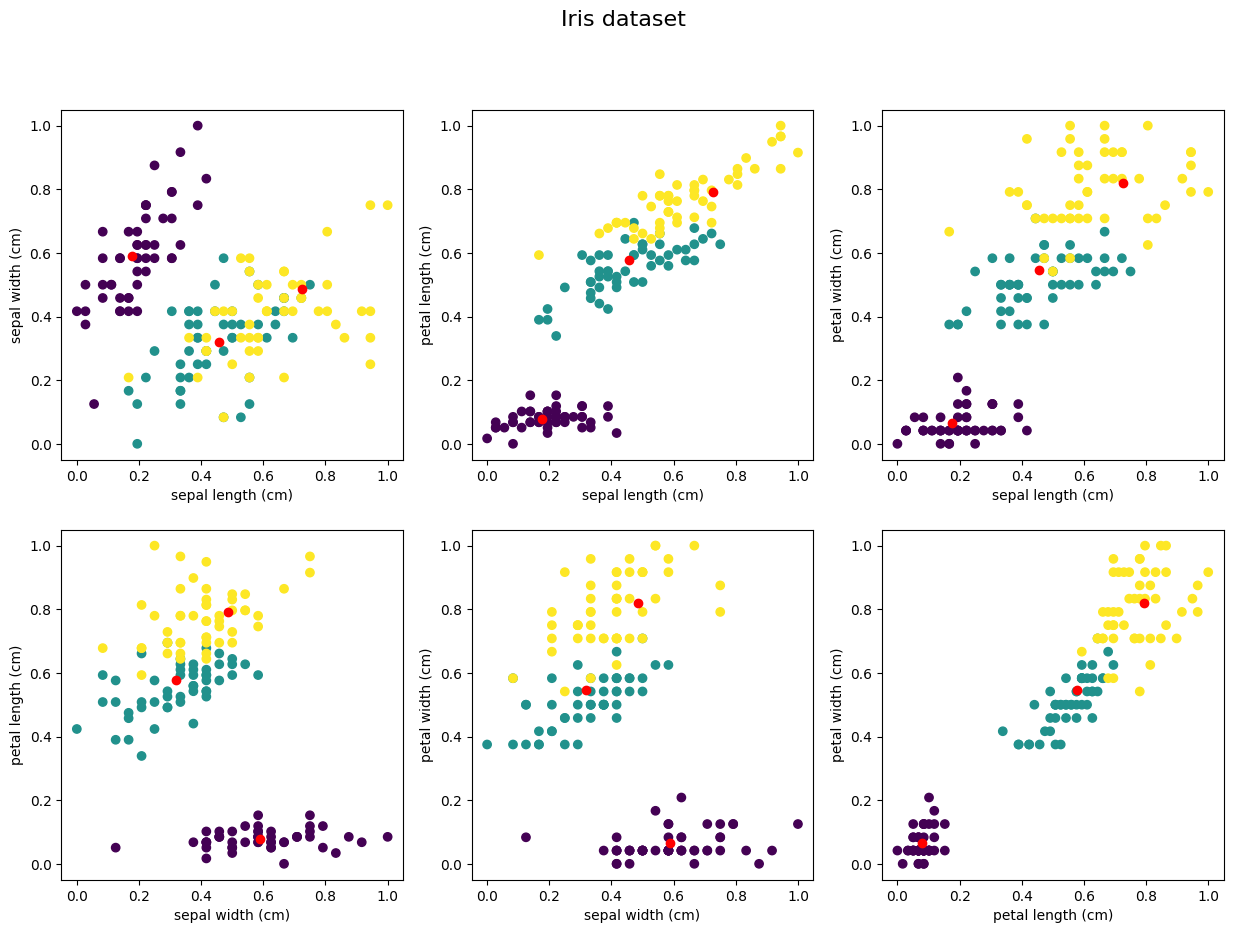

In [67]:
centroids = rbf_network.centroids

fig, (axes) = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes[0, 0].scatter(X[:, 0], X[:, 1], c=data["target"])
axes[0, 0].set_xlabel("sepal length (cm)")
axes[0, 0].set_ylabel("sepal width (cm)")
axes[0, 0].scatter(centroids[:, [0]], centroids[:, [1]], marker="o", c="red")

axes[0, 1].scatter(X[:, 0], X[:, 2], c=data["target"])
axes[0, 1].set_xlabel("sepal length (cm)")
axes[0, 1].set_ylabel("petal length (cm)")
axes[0, 1].scatter(centroids[:, [0]], centroids[:, [2]], marker="o", c="red")

axes[0, 2].scatter(X[:, 0], X[:, 3], c=data["target"])
axes[0, 2].set_xlabel("sepal length (cm)")
axes[0, 2].set_ylabel("petal width (cm)")
axes[0, 2].scatter(centroids[:, [0]], centroids[:, [3]], marker="o", c="red")

axes[1, 0].scatter(X[:, 1], X[:, 2], c=data["target"])
axes[1, 0].set_xlabel("sepal width (cm)")
axes[1, 0].set_ylabel("petal length (cm)")
axes[1, 0].scatter(centroids[:, [1]], centroids[:, [2]], marker="o", c="red")

axes[1, 1].scatter(X[:, 1], X[:, 3], c=data["target"])
axes[1, 1].set_xlabel("sepal width (cm)")
axes[1, 1].set_ylabel("petal width (cm)")
axes[1, 1].scatter(centroids[:, [1]], centroids[:, [3]], marker="o", c="red")

axes[1, 2].scatter(X[:, 2], X[:, 3], c=data["target"])
axes[1, 2].set_xlabel("petal length (cm)")
axes[1, 2].set_ylabel("petal width (cm)")
axes[1, 2].scatter(centroids[:, [2]], centroids[:, [3]], marker="o", c="red")

fig.suptitle("Iris dataset", fontsize=16)
plt.show()

А как дела с классификацией?

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      1.00      0.88        15
   virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



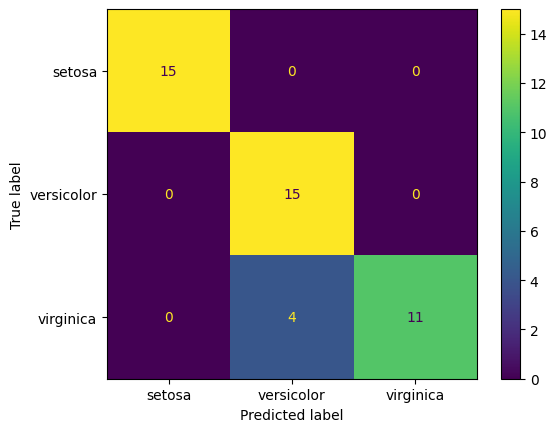

In [68]:
rbf_network.predict(test_x)

y_pred = rbf_network.predict(test_x)

y_pred_classes = [target_names[x] for x in np.argmax(y_pred, axis=1)]
y_true_classes = [target_names[x] for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

Сомнительно, но окей

Чтобы меньше париться, найдём веса с помощью градиентного спуска с самой простой сетью из 3-х нейронов

Слой Линейный! loss - RMSE.

Собственно, на входе у нас будет выход от РБФ функций, на выходе хотим всё тот же Y

In [69]:
network_train_x = rbf_network.calculate_h(train_x)
network_test_x = rbf_network.calculate_h(test_x)

In [70]:
network = NN(
    [
        Layer(3, 3, (lambda x: x, lambda x: np.ones_like(x))),
    ],
    loss_function=sklearn.metrics.root_mean_squared_error,
)
loss_history = []

Создадим экземпляр нашего перцептрона и обучим его


In [71]:
def train(
    network: NN,
    x: Nums,
    y: Nums,
    num_epoches: int,
    learning_rate: float,
    batch_size: int,
    loss_history: list
):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    for epoch in bar:
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)
        epoch_x = x[xy_indices]
        epoch_y = y[xy_indices]
        network.train(
            epoch_x,
            epoch_y,
            lambda: AdamOptimizer(0.9, 0.999),
            learning_rate=learning_rate,
            batch_size=batch_size,
        )

        loss = network.pop_loss(np.min)
        loss_history.append(loss)

        bar.set_description(
            f"epoch: {epoch}, loss: {loss:.10f}"
        )
        network.losses.clear()
    return loss_history


loss_history = train(network, network_train_x, train_y, 100, 0.004, 5, loss_history)

epoch: 100, loss: 0.5809264541: 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


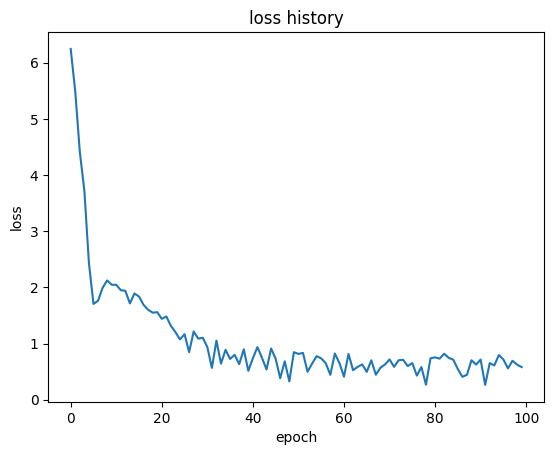

In [72]:
fig, ax = plt.subplots()

ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("loss history")
plt.show()

Посмотрим на результат обучения на валидационной выборке


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



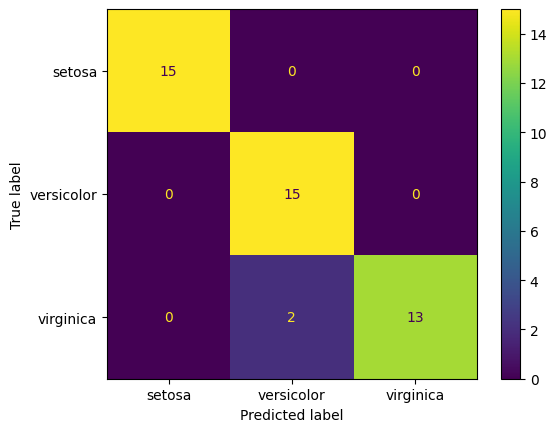

In [73]:
y_pred = network.forward(network_test_x)

y_pred_classes = [target_names[x] for x in np.argmax(y_pred, axis=1)]
y_true_classes = [target_names[x] for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

Это конечно здорово, но слабовато, попробуем решить иначе.
Вспомним теорему Ковера из лекции, попробуем повысить размерность до 50-ти

In [74]:
rbf_network = RBFNetwork(norm, gauss)
rbf_network.pre_fit(train_x, train_y, get_centroids, get_sigmas, num_clusters=30)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



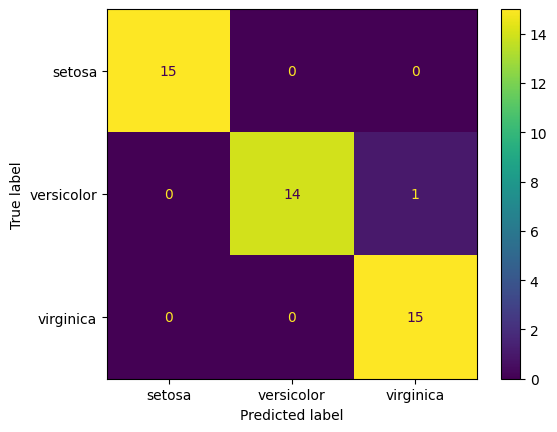

In [75]:
y_pred = rbf_network.predict(test_x)

y_pred_classes = [target_names[x] for x in np.argmax(y_pred, axis=1)]
y_true_classes = [target_names[x] for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

Вот и всё, делаешь так и спина болеть не будет!

Ура!
